In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sp
from scipy.integrate import odeint
from numpy.linalg import inv
import pdb
import scipy.io
from scipy.stats.distributions import chi2

In [39]:
data_file = scipy.io.loadmat('../DATA/cooplocalization_finalproj_KFdata.mat')
data_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr  9 16:24:23 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Qtrue': array([[0.001, 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.001, 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.01 , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.001, 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.001, 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.01 ]]),
 'Rtrue': array([[2.25e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 6.40e+01, 0.00e+00, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 4.00e-02, 0.00e+00, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 3.60e+01, 0.00e+00],
        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 3.60e+01]]),
 'measLabels': array([[array(['\\gamma_{ag} (rads)'], dtype='<U18'),
         array(['\\rho_{ga} (m)'], dtype='<U13'),
         array(['\\gamma_{ga} (rads)'], dtype='<U18'),
         array(['\\xi_a (m)'], dtype='<U9'),
        

In [91]:
#Initializations

x0 = np.array([10,0,np.pi/2,-60,0,-np.pi/2]).reshape(6,1)
u = np.array([2, -np.pi/18, 12, np.pi/25])
L = 0.5
delta_t = 0.1
time_steps = data_file['tvec'].transpose()
time_steps = time_steps.reshape(len(time_steps),)
#time_steps = np.linspace(0,500,5000)
Qtrue = data_file['Qtrue']
cholesky_decomposition_Qtrue = np.linalg.cholesky(Qtrue)
Rtrue = data_file['Rtrue']
cholesky_decomposition_Rtrue = np.linalg.cholesky(Rtrue)
plt.rcParams["figure.figsize"] = (15,15)

In [92]:
# # Qtrue = np.array([[0.00, 0.   , 0.   , 0.   , 0.   , 0.   ],
# #        [0.   , 0.00, 0.   , 0.   , 0.   , 0.   ],
# #        [0.   , 0.   , 0.0 , 0.   , 0.   , 0.   ],
# #        [0.   , 0.   , 0.   , 0.00, 0.   , 0.   ],
# #        [0.   , 0.   , 0.   , 0.   , 0.00, 0.   ],
# #        [0.   , 0.   , 0.   , 0.   , 0.   , 0.0 ]])
# # Rtrue = np.array([[0, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
# #        [0.00e+00, 0, 0.00e+00, 0.00e+00, 0.00e+00],
# #        [0.00e+00, 0.00e+00, 0, 0.00e+00, 0.00e+00],
# #        [0.00e+00, 0.00e+00, 0.00e+00, 0, 0.00e+00],
# #        [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0]])
# # cholesky_decomposition_Qtrue = Qtrue
# # cholesky_decomposition_Rtrue = Rtrue
# Qtrue = np.zeros((6,6))
# Rtrue = np.zeros((5,5))
# cholesky_decomposition_Qtrue = np.zeros((6,6))
# cholesky_decomposition_Rtrue = np.zeros((5,5))

In [93]:
#Generate True data with noise

def model(x, t, u, noise, L):
    e_g = x[0]
    n_g = x[1]
    theta_g = x[2]
    e_a = x[3]
    n_a = x[4]
    theta_a = x[5]
    v_g = u[0]
    phi_g = u[1]
    v_a = u[2]
    w_a = u[3] 
    dxdt = [0]*6
    dxdt[0] = v_g*np.cos(theta_g) + noise[0][0]
    dxdt[1] = v_g*np.sin(theta_g) + noise[1][0]
    dxdt[2] = (v_g/L)*np.tan(phi_g) + noise[2][0]
    dxdt[3] = v_a*np.cos(theta_a) + noise[3][0]
    dxdt[4] = v_a*np.sin(theta_a) + noise[4][0]
    dxdt[5] = w_a + noise[5][0]
    return dxdt

def calculate_exact_yt(x,v):
    temptop = (x[4]-x[1])
    tempbot = (x[3]-x[0])
    y1 = np.arctan2(temptop,tempbot) - (x[2])
    if y1 < 0:
        y1 = y1 + 2*np.pi
    y1 = y1 - np.pi
    y2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
    y3 = np.arctan2(-temptop,-tempbot) - (x[5])
    if y3 < 0:
        y3 = y3 + 2*np.pi
    y4 = x[3]
    y5 = x[4]
    
    yt = np.array([
                [y1],
                [y2],
                [y3],
                [y4],
                [y5]
                ])
    yt = yt + v
    return yt

def get_sample_noise(S):
    n = len(S)
    std_normal_covar_matrix = np.identity(n)
    std_normal_mean_matrix = np.zeros(n)
    sampled_noise_with_covar_I = np.random.multivariate_normal(std_normal_mean_matrix, std_normal_covar_matrix).reshape(n,1)
    sampled_noise_with_covar_Q = np.dot(S,sampled_noise_with_covar_I)
    return sampled_noise_with_covar_Q

def wrap_in_negative_pi_to_pi(theta):
    wrapped_angle = (theta + np.pi) % (2 * np.pi) - np.pi
    return wrapped_angle

def get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L):
    Xtrue = [x0]
    n = len(x0)
    for i in range(1,len(time_steps)):
        w = get_sample_noise(cholesky_decomposition_Qtrue)
        xk = Xtrue[-1]
        xk_plus1 = odeint(model, xk.reshape(n,), np.linspace(0, 0.1, 2), args = (u,w,L))
        xk_plus1 = xk_plus1[-1]
        xk_plus1[2] = wrap_in_negative_pi_to_pi(xk_plus1[2])
        xk_plus1[5] = wrap_in_negative_pi_to_pi(xk_plus1[5])
        xk_plus1 = xk_plus1.reshape(n,1)
        Xtrue.append(xk_plus1)    
    return Xtrue

def get_Ytrue(Xtrue,cholesky_decomposition_Rtrue):
    Ytrue = []
    n = len(Xtrue[0])
    for i in range(0,len(Xtrue)):
        v = get_sample_noise(cholesky_decomposition_Rtrue)
        yk = calculate_exact_yt(Xtrue[i].reshape(n,),v)
        Ytrue.append(yk)    
    return Ytrue

# Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L)
# Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_Rtrue)

In [94]:
#Jacobians

def get_CT_Jacobians(x,u,time_update_flag,measurement_update_flag):
    
    A = 0; B = 0; Ga = 0; C = 0; D = 0
    
    if(time_update_flag):    
        A = np.array([
                [0, 0, -u[0]*np.sin(x[2]), 0, 0, 0],
                [0, 0, u[0]*np.cos(x[2]), 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, -u[2]*np.sin(x[5])],
                [0, 0, 0, 0, 0, u[2]*np.cos(x[5])],
                [0, 0, 0, 0, 0, 0]])

        Ga = np.eye(6)
    
    if(measurement_update_flag):
    
        denominator_1 = 1 + ((x[4]-x[1])/(x[3]-x[0]))**2
        numerator_11 = (x[4]-x[1]) / ((x[3] - x[0])**2)
        C11 = numerator_11/denominator_1

        numerator_12 = -1/(x[3]-x[0])
        C12 = numerator_12/denominator_1

        C14 = -1*C11
        C15 = -1*C12

        denominator_2 = ( (x[0]-x[3])**2 + (x[1]-x[4])**2 ) ** 0.5
        C21 = (x[0]-x[3])/denominator_2
        C22 = (x[1]-x[4])/denominator_2
        C24 = -1*C21
        C25 = -1*C22

        C = np.array([
                [C11, C12, -1, C14, C15, 0],
                [C21, C22, 0, C24, C25, 0],
                [C11, C12, 0, C14, C15, -1],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0]
                ])
    
    return A,B, Ga, C, D

def get_DT_Jacobians(x,u,dt,time_update_flag,measurement_update_flag):
    
    A,B,Gamma,C,D = get_CT_Jacobians(x,u,time_update_flag,measurement_update_flag)
    F = 0; G = 0; Omega = 0; H = 0; M = 0
    if(time_update_flag):
        F = np.eye(6) + dt*A
        Omega = delta_t*Gamma
    if(measurement_update_flag):
        H = C
        M = D
    
    return F,G,Omega,H,M

In [95]:
#Extended Kalman Filter

def kf_time_update(xk,Pk,uk,Q):
    n = len(xk)
    noise = np.zeros(n).reshape(n,1)
    #Calculate Jacobians    
    Fk,Gk,Omegak,Hk,Mk = get_DT_Jacobians(xk.reshape(n,),uk,delta_t,True,False)
    #Calculate x(k+1) minus
    #Note x(k+1) minus is of shape (n,) (just one dimension)
    xk_propogated = odeint(model, xk.reshape(n,), np.linspace(0, 0.1, 2), args = (u,noise,L))
    xk_propogated = xk_propogated[-1]
    xk_propogated[2] = wrap_in_negative_pi_to_pi(xk_propogated[2])
    xk_propogated[5] = wrap_in_negative_pi_to_pi(xk_propogated[5]) 
    #Calculate P(k+1) minus
    Pk_propogated = np.dot(Fk,np.dot(Pk,Fk.transpose())) + np.dot(Omegak,np.dot(Q,Omegak.transpose()))
    
    return xk_propogated, Pk_propogated

def kf_measurement_update(xk_propogated,Pk_propogated,yk_observed,uk,R):
    #noise
    p = len(yk_observed)
    v = np.zeros(p).reshape(p,1)
    yk_predicted = calculate_exact_yt(xk_propogated,v)
    surprise_factor = yk_observed - yk_predicted
    surprise_factor[0][0] = wrap_in_negative_pi_to_pi(surprise_factor[0][0])
    surprise_factor[2][0] = wrap_in_negative_pi_to_pi(surprise_factor[2][0])
    #Calculate Jacobians
    Fk_plus1_minus,Gk_plus1_minus,Omegak_plus1_minus,Hk_plus1_minus,Mk_plus1_minus = get_DT_Jacobians(xk_propogated,uk,delta_t,False,True)
    #Calculate Kalman Gain
    fc_kalman_gain = np.dot(Pk_propogated,Hk_plus1_minus.transpose())
    sc_kalman_gain = np.dot(Hk_plus1_minus,np.dot(Pk_propogated,Hk_plus1_minus.transpose())) + R
    kalman_gain = np.dot(fc_kalman_gain,inv(sc_kalman_gain))
    #Calculate x(k+1) plus
    n = len(xk_propogated)
    xk_plus1 = xk_propogated.reshape(n,1) + np.dot(kalman_gain,surprise_factor)
    xk_plus1[2][0] = wrap_in_negative_pi_to_pi(xk_plus1[2][0])
    xk_plus1[5][0] = wrap_in_negative_pi_to_pi(xk_plus1[5][0]) 
    #Calculate P(k+1) plus
    I = np.identity(n)
    fc_Pk_plus1 = I - np.dot(kalman_gain,Hk_plus1_minus)
    Pk_plus1 = np.dot(fc_Pk_plus1, Pk_propogated)
    
    return xk_plus1,Pk_plus1,sc_kalman_gain

def get_estimated_states_and_measurements(x0,P0,u,observed_measurements_list,Q,R):
    xk = x0
    Pk = P0
    estimated_state_list = [xk]
    estimated_covariance_matrix_list = [Pk]
    estimated_measurement_list = []
    innovation_covariance_matrix_list = []
    n = len(x0)
    p = len(observed_measurements_list[0])
    zero_measurement_noise = np.zeros(p).reshape(p,1)
    for observed_measurement in observed_measurements_list[1:]:
        xk_propogated,Pk_propogated = kf_time_update(xk,Pk,u,Q)
        xk_plus1,Pk_plus1,innovation_covariance_matrix = kf_measurement_update(xk_propogated,Pk_propogated,observed_measurement,u,R)
        estimated_measurement = calculate_exact_yt(xk_propogated,zero_measurement_noise)
        estimated_state_list.append(xk_plus1)
        estimated_covariance_matrix_list.append(Pk_plus1)
        estimated_measurement_list.append(estimated_measurement)
        innovation_covariance_matrix_list.append(innovation_covariance_matrix)
        xk = xk_plus1
        Pk = Pk_plus1

    return estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list
    

#estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list = get_estimated_states_and_measurements(x0, Qtrue, u, Ytrue, Qtrue, Rtrue)

In [96]:
#NEES and NIS

def get_weighted_error_x_at_step_k(actual_x,estimated_x,Pk):
    ek = actual_x - estimated_x
    ek[2][0] = wrap_in_negative_pi_to_pi(ek[2][0])
    ek[5][0] = wrap_in_negative_pi_to_pi(ek[5][0])
    epsilon = np.dot(ek.transpose(),np.dot(inv(Pk),ek))
    return epsilon[0][0]

def get_epsilon_x_for_all_time_steps_in_one_simulation(actual_x_list, estimated_x_list, estimated_P_list):
    epsilon_x_list = []
    for k in range(0,len(actual_x_list)):
        epsilon_at_step_k = get_weighted_error_x_at_step_k(actual_x_list[k],estimated_x_list[k],estimated_P_list[k])
        epsilon_x_list.append(epsilon_at_step_k)
        
    return epsilon_x_list

def get_weighted_error_y_at_step_k(actual_y,estimated_y,Sk):
    ek = actual_y - estimated_y
    ek[0][0] = wrap_in_negative_pi_to_pi(ek[0][0])
    ek[2][0] = wrap_in_negative_pi_to_pi(ek[2][0])
    epsilon = np.dot(ek.transpose(),np.dot(inv(Sk),ek))
    return epsilon[0][0]

def get_epsilon_y_for_all_time_steps_in_one_simulation(actual_y_list, estimated_y_list, estimated_S_list):
    epsilon_y_list = []
    for k in range(0,len(actual_y_list)):
        epsilon_at_step_k = get_weighted_error_y_at_step_k(actual_y_list[k],estimated_y_list[k],estimated_S_list[k])
        epsilon_y_list.append(epsilon_at_step_k)
        
    return epsilon_y_list

def get_NEES_data_for_multiple_simulations(x0,P0,u,Qtrue,Rtrue,Qfilter,Rfilter,num_mc_simulations):
    NEES_data = np.zeros(shape=(num_mc_simulations,len(time_steps)))
    NIS_data = np.zeros(shape=(num_mc_simulations,len(time_steps)-1))
    cholesky_decomposition_Q = np.linalg.cholesky(Qtrue)
    cholesky_decomposition_R = np.linalg.cholesky(Rtrue)
#     cholesky_decomposition_Q = Qtrue
#     cholesky_decomposition_R = Rtrue
    
    for i in range(0,num_mc_simulations):
        print("Performing simulation number " + str(i))
        Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Q,L)
        Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_R)

        estimated_state_list,estimated_covariance_matrix_list,\
        estimated_measurement_list,innovation_covariance_matrix_list = \
        get_estimated_states_and_measurements(x0, P0, u, Ytrue, Qfilter, Rfilter)

        epsilon_x_for_all_time_steps_in_one_simulation = \
        get_epsilon_x_for_all_time_steps_in_one_simulation(Xtrue,estimated_state_list, \
                                                           estimated_covariance_matrix_list)
        
        epsilon_y_for_all_time_steps_in_one_simulation = get_epsilon_y_for_all_time_steps_in_one_simulation \
        (Ytrue[1:],estimated_measurement_list, innovation_covariance_matrix_list)

        
        NEES_data[i] = np.array(epsilon_x_for_all_time_steps_in_one_simulation)
        NIS_data[i] = np.array(epsilon_y_for_all_time_steps_in_one_simulation)
        
    return NEES_data,NIS_data

#NEES_data,NIS_data = get_NEES_data_for_multiple_simulations(x0,Qtrue,u,(999999)*Qtrue,Rtrue,Qtrue,Rtrue,10)

In [125]:
#Tuning EKF by changing Qfilter 

Q11 = 10
Q13 = 0
Q22 = 10
Q23 = 0
Q33 = 100
Q44 = 10
Q46 = 0
Q55 = 10
Q56 = 0
Q66 = 100

Qfilter = np.array([
        [Q11,    0.,    Q13   , 0.   , 0.   , 0.   ],
        [0. ,    Q22,   Q23   , 0.   , 0.   , 0.   ],
        [Q13,    Q23,   Q33   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , Q44    , 0.   , Q46   ],
        [0.   , 0.   , 0.   , 0.     , Q55  , Q56   ],
        [0.   , 0.   , 0.   , Q46    , Q56  , Q66 ]
    ])

Qfilter = 1*data_file['Qtrue']
Pstart = 100*data_file['Qtrue']

# Pstart = np.array([[10, 0.   , 0.   , 0.   , 0.   , 0.   ],
#        [0.   , 10, 0.   , 0.   , 0.   , 0.   ],
#        [0.   , 0.   , 10 , 0.   , 0.   , 0.   ],
#        [0.   , 0.   , 0.   , 10, 0.   , 0.   ],
#        [0.   , 0.   , 0.   , 0.   , 10, 0.   ],
#        [0.   , 0.   , 0.   , 0.   , 0.   , 10 ]])

In [126]:
# Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L)
# Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_Rtrue)

# estimated_state_list,estimated_covariance_matrix_list,\
# estimated_measurement_list,innovation_covariance_matrix_list = get_estimated_states_and_measurements(x0, Qtrue, u, Ytrue, Qtrue, Rtrue)

# epsilon_x_for_all_time_steps_in_one_simulation = \
# get_epsilon_x_for_all_time_steps_in_one_simulation(Xtrue,estimated_state_list,estimated_covariance_matrix_list)

# epsilon_y_for_all_time_steps_in_one_simulation = get_epsilon_y_for_all_time_steps_in_one_simulation \
# (Ytrue[1:],estimated_measurement_list, innovation_covariance_matrix_list)

# get_weighted_error_x_at_step_k(Xtrue[10],estimated_state_list[10],estimated_covariance_matrix_list[10])

# get_epsilon_x_for_all_time_steps_in_one_simulation(Xtrue,estimated_state_list,estimated_covariance_matrix_list)

# get_epsilon_y_for_all_time_steps_in_one_simulation(Ytrue[1:], estimated_measurement_list, innovation_covariance_matrix_list )

In [127]:
Xtrue = get_Xtrue(x0,time_steps,cholesky_decomposition_Qtrue,L)
Ytrue = get_Ytrue(Xtrue,cholesky_decomposition_Rtrue)
estimated_state_list,estimated_covariance_matrix_list,estimated_measurement_list,innovation_covariance_matrix_list = get_estimated_states_and_measurements(x0, Pstart, u, Ytrue, Qfilter, Rtrue)
skip_till = 0

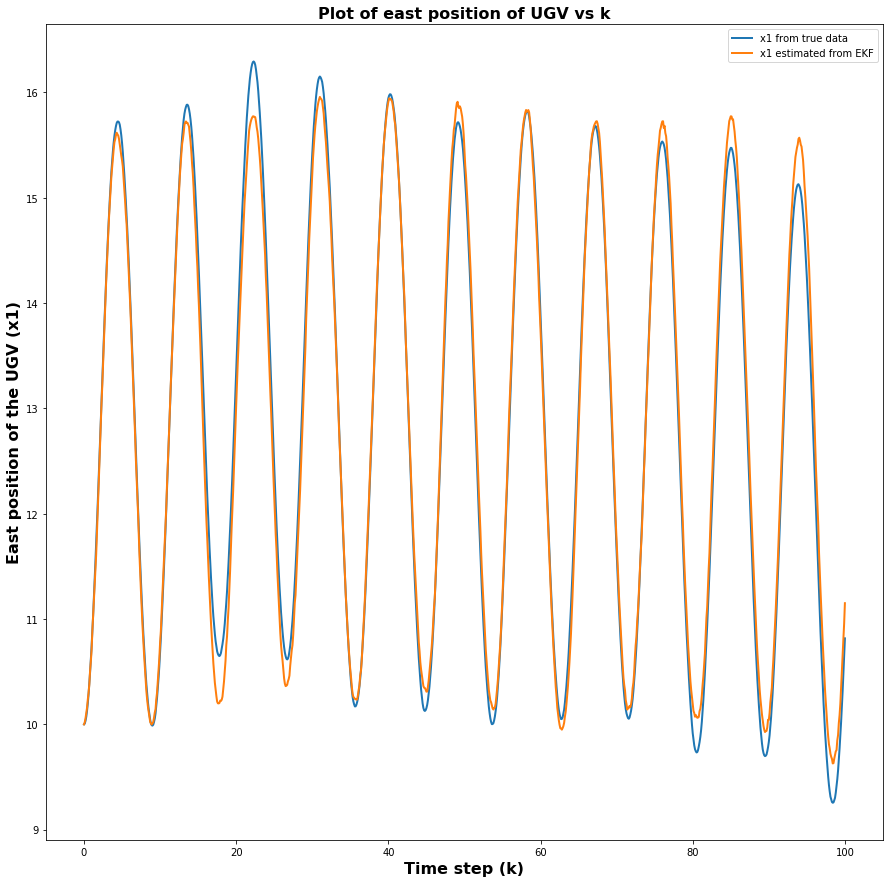

In [128]:
#Plot x[1] or east position of UGV

true_x1 = []
estimated_x1 = []

for state in Xtrue:
    true_x1.append(state[0][0])
    
for state in estimated_state_list:
    estimated_x1.append(state[0][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("East position of the UGV (x1)",fontsize=16, fontweight='bold')
plt.title("Plot of east position of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x1,linewidth = 2,label = 'x1 from true data')
plt.plot(time_steps,estimated_x1,linewidth = 2,label = 'x1 estimated from EKF')
plt.legend()



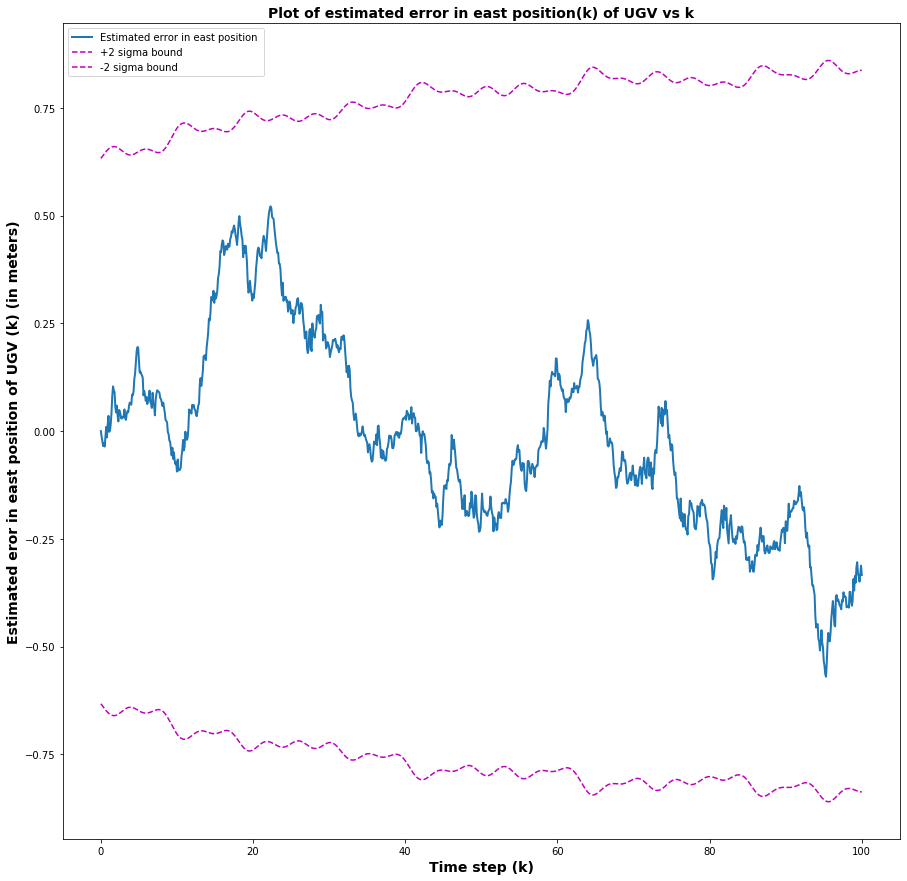

In [129]:
#Error in East Position of UGV
estimated_state1_error_list = []
positive_two_sigma_state_element1_list = []
negative_two_sigma_state_element1_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x1[i]
    curr_variance = estimated_covariance_matrix_list[i][0][0]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x1[i] - curr_estimate
    estimated_state1_error_list.append(curr_error)
    positive_two_sigma_state_element1_list.append(bound)
    negative_two_sigma_state_element1_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in east position of UGV (k) (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in east position(k) of UGV vs k",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],estimated_state1_error_list[skip_till:],linewidth = 2,label = 'Estimated error in east position ')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element1_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element1_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

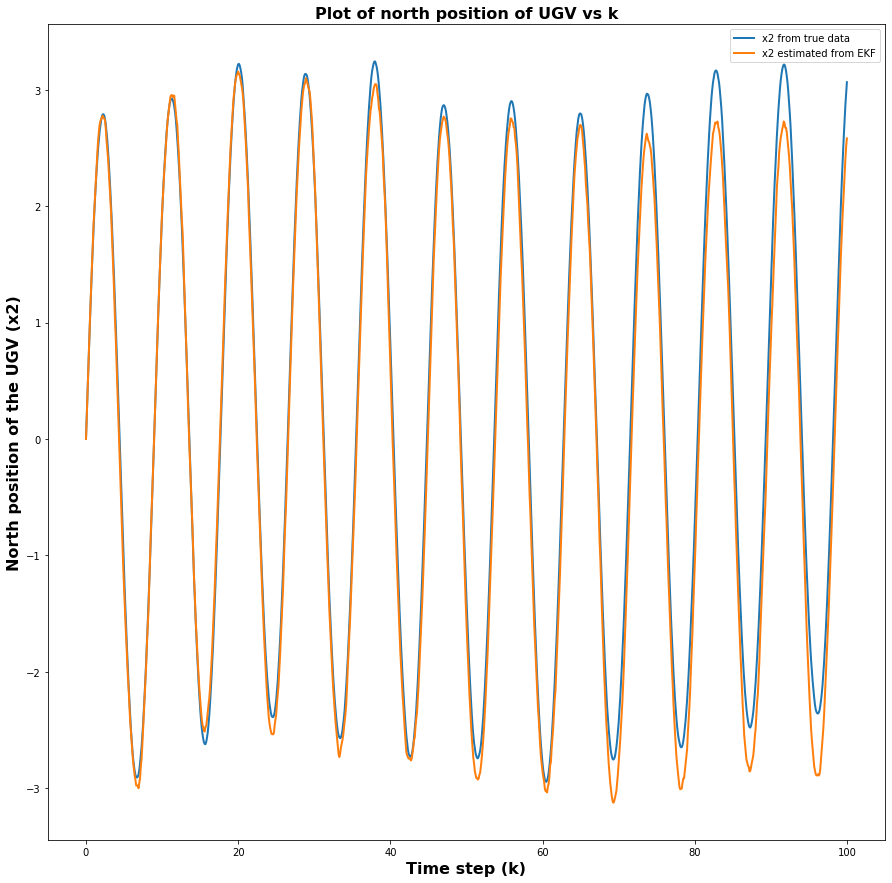

In [130]:
#Plot x[2] or north position of UGV

true_x2 = []
estimated_x2 = []

for state in Xtrue:
    true_x2.append(state[1][0])
    
for state in estimated_state_list:
    estimated_x2.append(state[1][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("North position of the UGV (x2)",fontsize=16, fontweight='bold')
plt.title("Plot of north position of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x2,linewidth = 2,label = 'x2 from true data')
plt.plot(time_steps,estimated_x2,linewidth = 2,label = 'x2 estimated from EKF')
plt.legend()



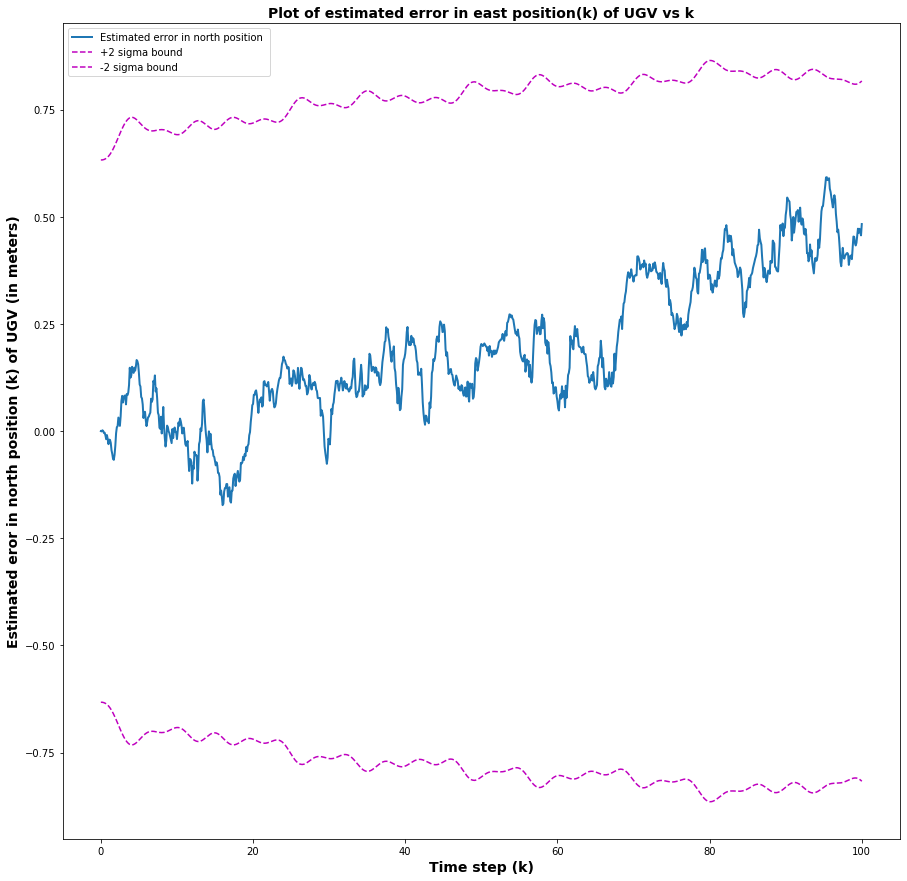

In [131]:
#Error in North Position of UGV
estimated_state2_error_list = []
positive_two_sigma_state_element2_list = []
negative_two_sigma_state_element2_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x2[i]
    curr_variance = estimated_covariance_matrix_list[i][1][1]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x2[i] - curr_estimate
    estimated_state2_error_list.append(curr_error)
    positive_two_sigma_state_element2_list.append(bound)
    negative_two_sigma_state_element2_list.append(-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in north position (k) of UGV (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in east position(k) of UGV vs k",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],estimated_state2_error_list[skip_till:],linewidth = 2,label = 'Estimated error in north position ')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element2_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element2_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

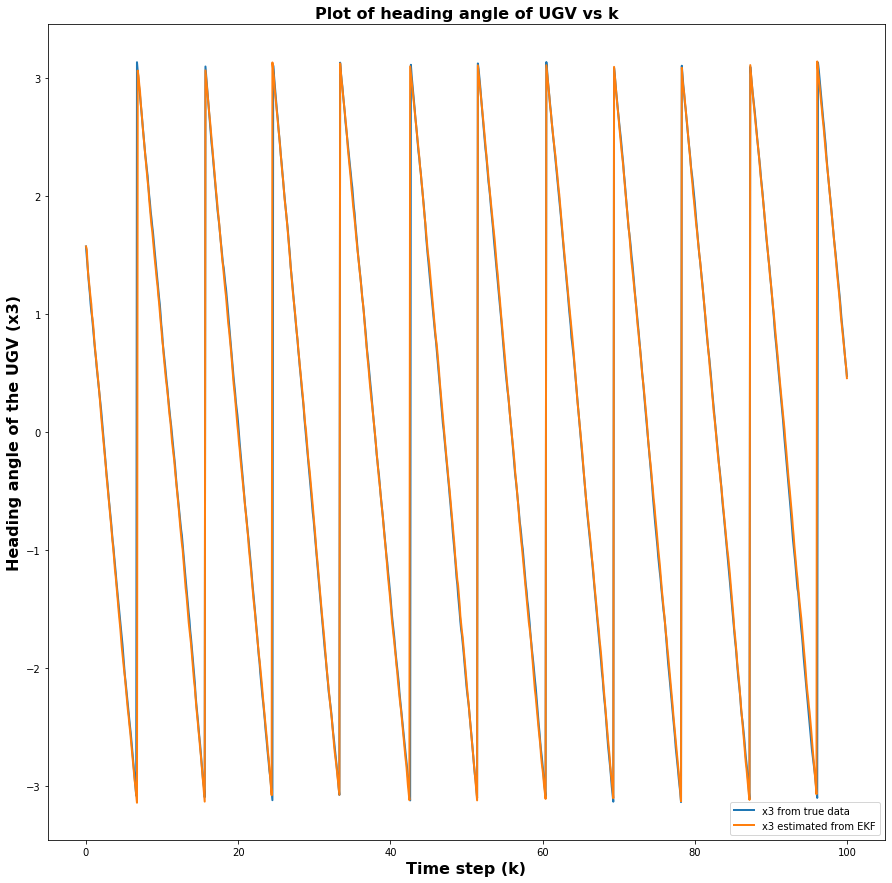

In [132]:
#Plot x[3] or heading angle of UGV

true_x3 = []
estimated_x3 = []

for state in Xtrue:
    true_x3.append(state[2][0])
    
for state in estimated_state_list:
    estimated_x3.append(state[2][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("Heading angle of the UGV (x3)",fontsize=16, fontweight='bold')
plt.title("Plot of heading angle of UGV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x3,linewidth = 2,label = 'x3 from true data')
plt.plot(time_steps,estimated_x3,linewidth = 2,label = 'x3 estimated from EKF')
plt.legend()



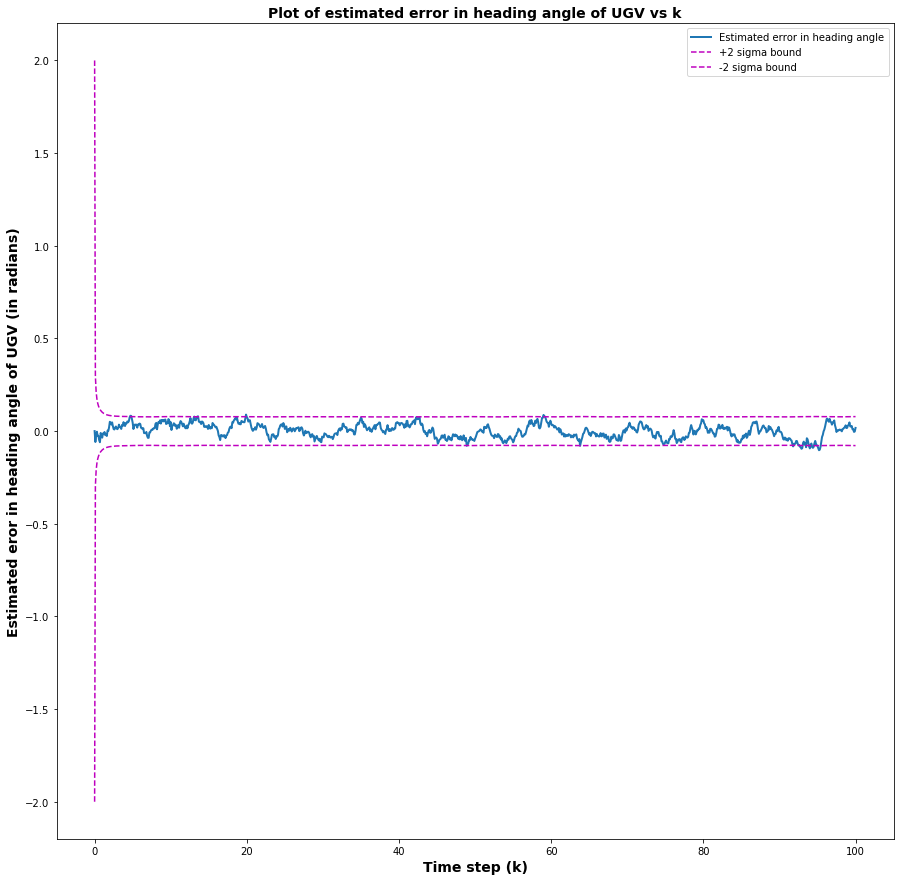

In [133]:
#Error in heading angle of UGV
estimated_state3_error_list = []
positive_two_sigma_state_element3_list = []
negative_two_sigma_state_element3_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x3[i]
    curr_variance = estimated_covariance_matrix_list[i][2][2]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x3[i] - curr_estimate
    curr_error = wrap_in_negative_pi_to_pi(curr_error)
    estimated_state3_error_list.append(curr_error)
    positive_two_sigma_state_element3_list.append(bound)
    negative_two_sigma_state_element3_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in heading angle of UGV (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in heading angle of UGV vs k",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],estimated_state3_error_list[skip_till:],linewidth = 2,label = 'Estimated error in heading angle')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element3_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element3_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

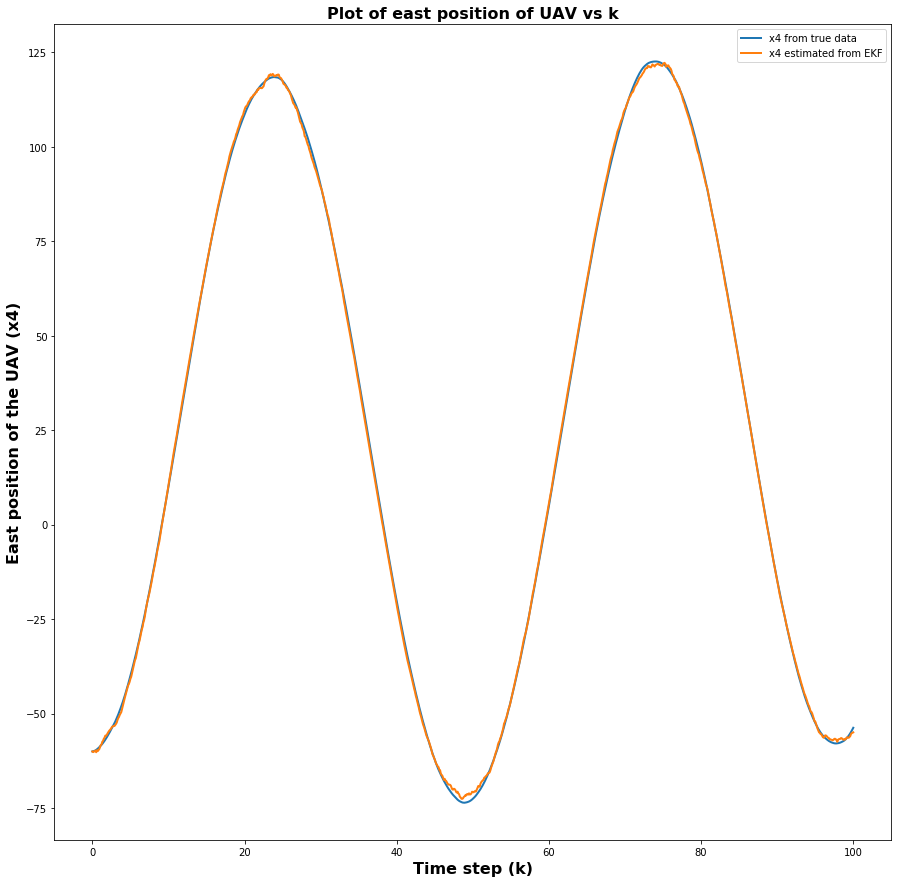

In [134]:
#Plot x[4] or east position of UAV

true_x4 = []
estimated_x4 = []

for state in Xtrue:
    true_x4.append(state[3][0])
    
for state in estimated_state_list:
    estimated_x4.append(state[3][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("East position of the UAV (x4)",fontsize=16, fontweight='bold')
plt.title("Plot of east position of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x4,linewidth = 2,label = 'x4 from true data')
plt.plot(time_steps,estimated_x4,linewidth = 2,label = 'x4 estimated from EKF')

plt.legend()



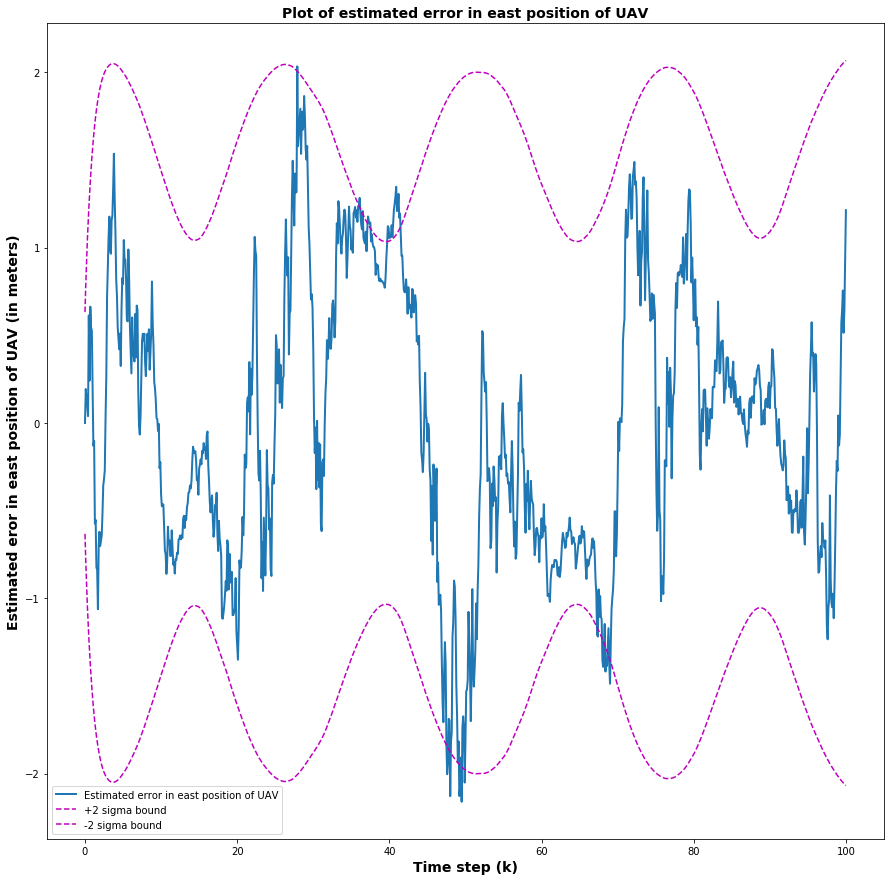

In [135]:
#Error in east position of UAV
estimated_state4_error_list = []
positive_two_sigma_state_element4_list = []
negative_two_sigma_state_element4_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x4[i]
    curr_variance = estimated_covariance_matrix_list[i][3][3]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x4[i] - curr_estimate
    estimated_state4_error_list.append(curr_error)
    positive_two_sigma_state_element4_list.append(bound)
    negative_two_sigma_state_element4_list.append(-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in east position of UAV (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in east position of UAV",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],estimated_state4_error_list[skip_till:],linewidth = 2,label = 'Estimated error in east position of UAV')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element4_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element4_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

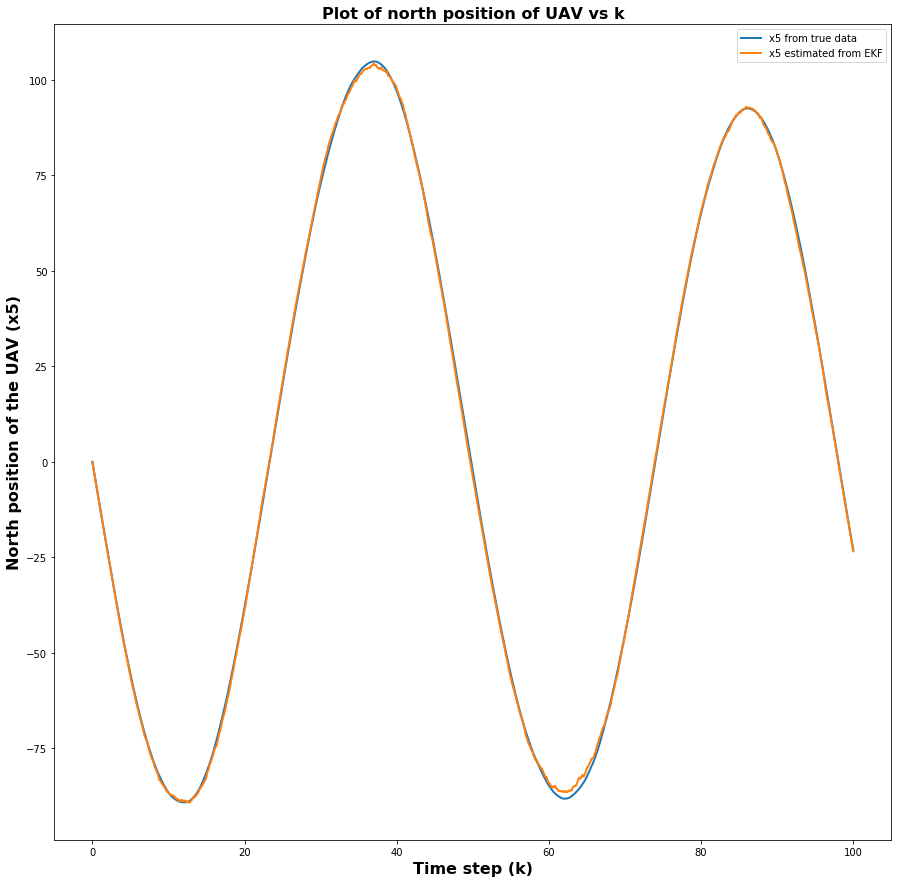

In [136]:
#Plot x[5] or north position of UAV

true_x5 = []
estimated_x5 = []

for state in Xtrue:
    true_x5.append(state[4][0])
    
for state in estimated_state_list:
    estimated_x5.append(state[4][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("North position of the UAV (x5)",fontsize=16, fontweight='bold')
plt.title("Plot of north position of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x5,linewidth = 2,label = 'x5 from true data')
plt.plot(time_steps,estimated_x5,linewidth = 2,label = 'x5 estimated from EKF')
plt.legend()



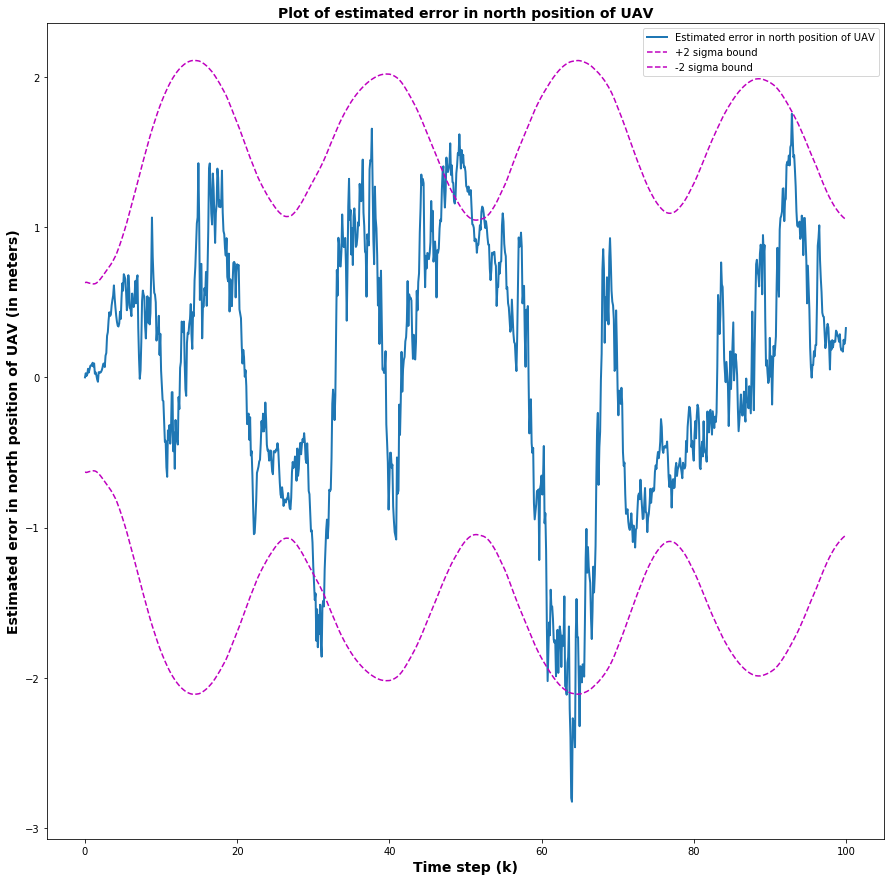

In [137]:
#Error in north position of UAV
estimated_state5_error_list = []
positive_two_sigma_state_element5_list = []
negative_two_sigma_state_element5_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x5[i]
    curr_variance = estimated_covariance_matrix_list[i][4][4]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x5[i] - curr_estimate
    estimated_state5_error_list.append(curr_error)
    positive_two_sigma_state_element5_list.append(bound)
    negative_two_sigma_state_element5_list.append(-bound)
    
plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in north position of UAV (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in north position of UAV",fontsize=14, fontweight='bold')
plt.plot(time_steps[skip_till:],estimated_state5_error_list[skip_till:],linewidth = 2,label = 'Estimated error in north position of UAV')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element5_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element5_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

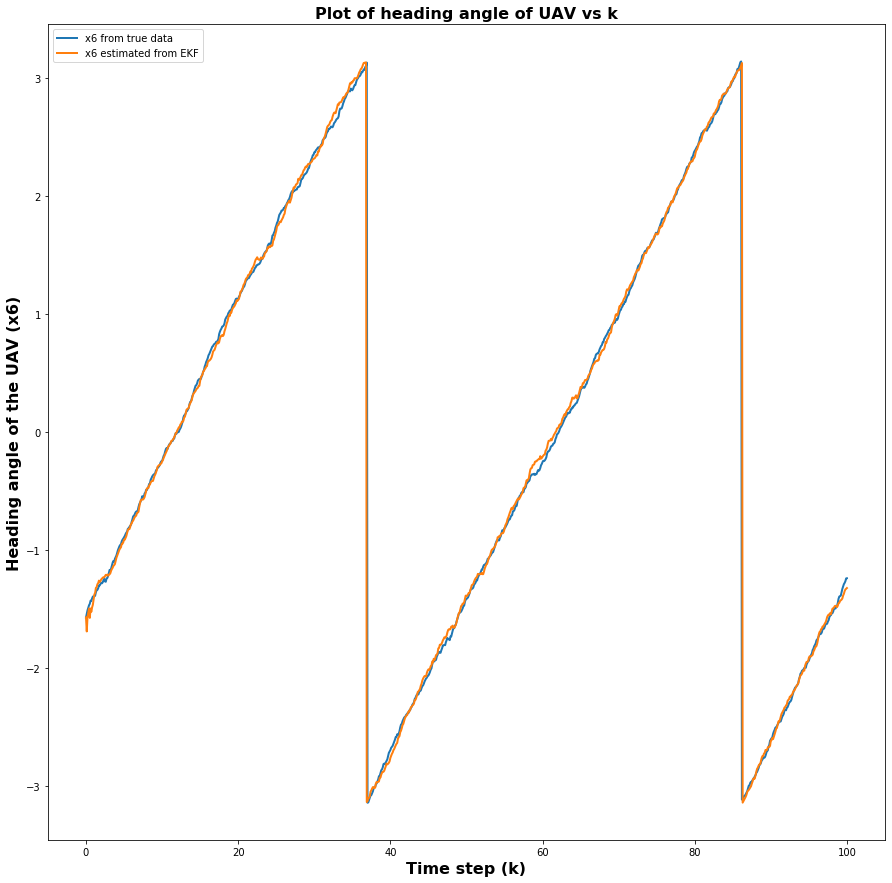

In [138]:
#Plot x[6] or heading angle of UAV

true_x6 = []
estimated_x6 = []

for state in Xtrue:
    true_x6.append(state[5][0])
    
for state in estimated_state_list:
    estimated_x6.append(state[5][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("Heading angle of the UAV (x6)",fontsize=16, fontweight='bold')
plt.title("Plot of heading angle of UAV vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps,true_x6,linewidth = 2,label = 'x6 from true data')
plt.plot(time_steps,estimated_x6,linewidth = 2,label = 'x6 estimated from EKF')
plt.legend()



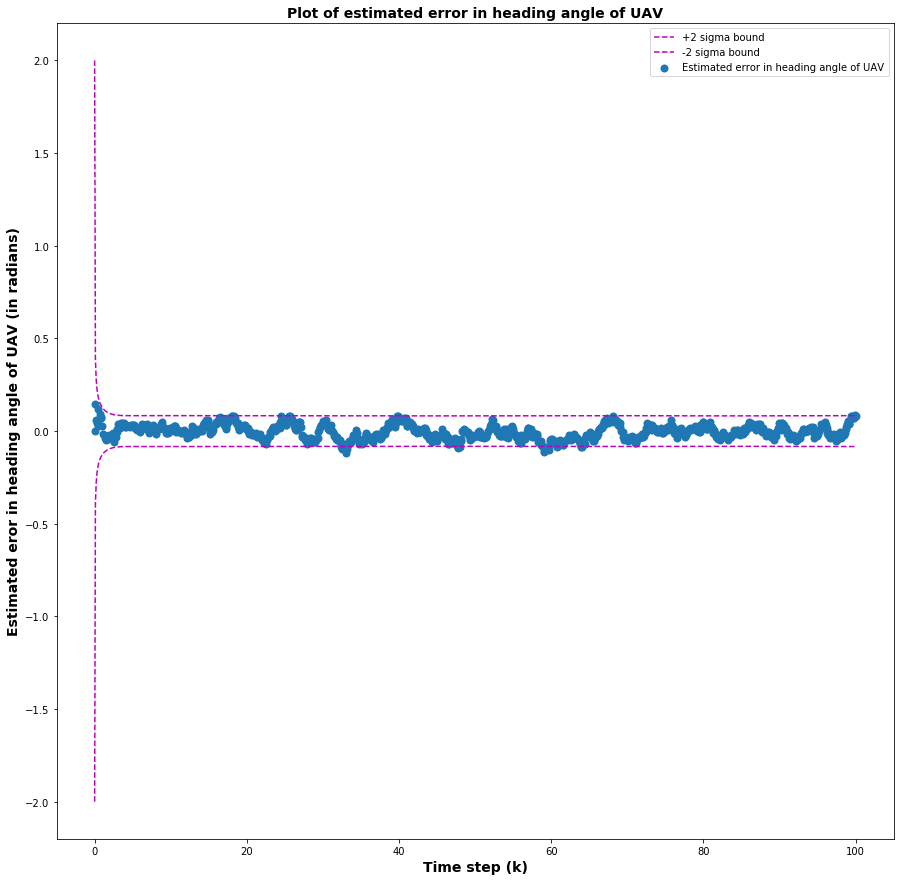

In [139]:
#Error in heading angle of UAV
estimated_state6_error_list = []
positive_two_sigma_state_element6_list = []
negative_two_sigma_state_element6_list = []

for i in range(0,len(estimated_state_list)):
    curr_estimate = estimated_x6[i]
    curr_variance = estimated_covariance_matrix_list[i][5][5]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_x6[i] - curr_estimate
    curr_error = wrap_in_negative_pi_to_pi(curr_error)
    estimated_state6_error_list.append(curr_error)
    positive_two_sigma_state_element6_list.append(bound)
    negative_two_sigma_state_element6_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in heading angle of UAV (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in heading angle of UAV",fontsize=14, fontweight='bold')
plt.scatter(time_steps[skip_till:],estimated_state6_error_list[skip_till:],linewidth = 2,label = 'Estimated error in heading angle of UAV')
plt.plot(time_steps[skip_till:],positive_two_sigma_state_element6_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[skip_till:],negative_two_sigma_state_element6_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

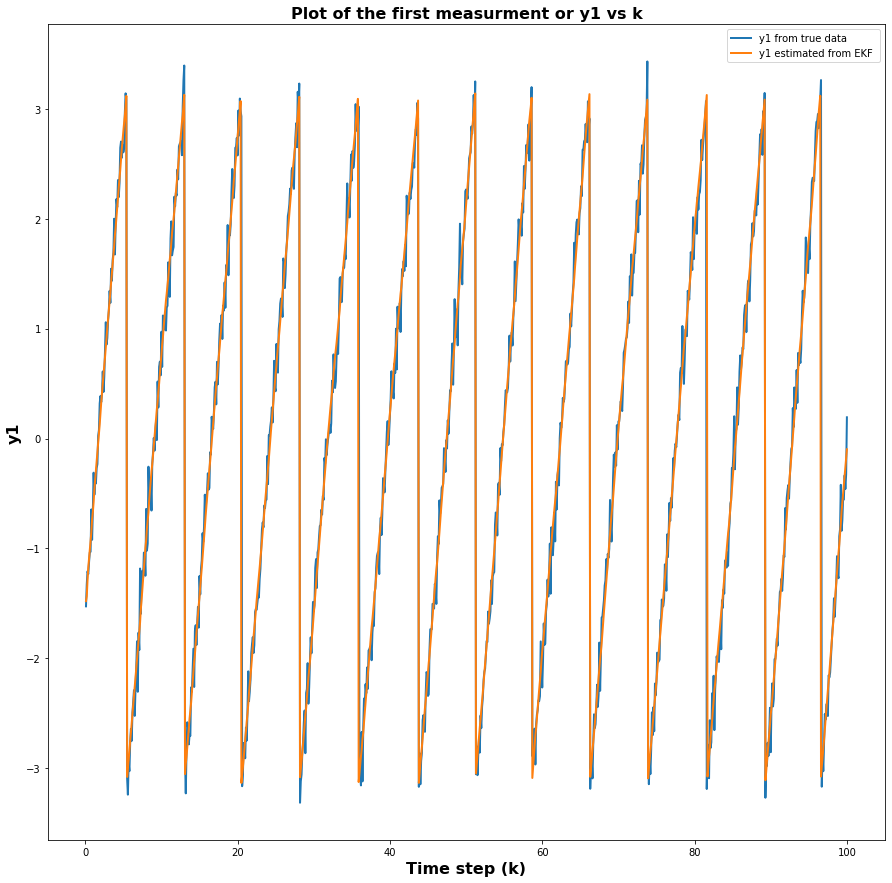

In [140]:
#Plot y[1]

true_y1 = []
estimated_y1 = []

for state in Ytrue[1:]:
    true_y1.append(state[0][0])
    
for state in estimated_measurement_list:
    estimated_y1.append(state[0][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y1",fontsize=16, fontweight='bold')
plt.title("Plot of the first measurment or y1 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps[1:],true_y1,linewidth = 2,label = 'y1 from true data')
plt.plot(time_steps[1:],estimated_y1,linewidth = 2,label = 'y1 estimated from EKF ')
plt.legend()

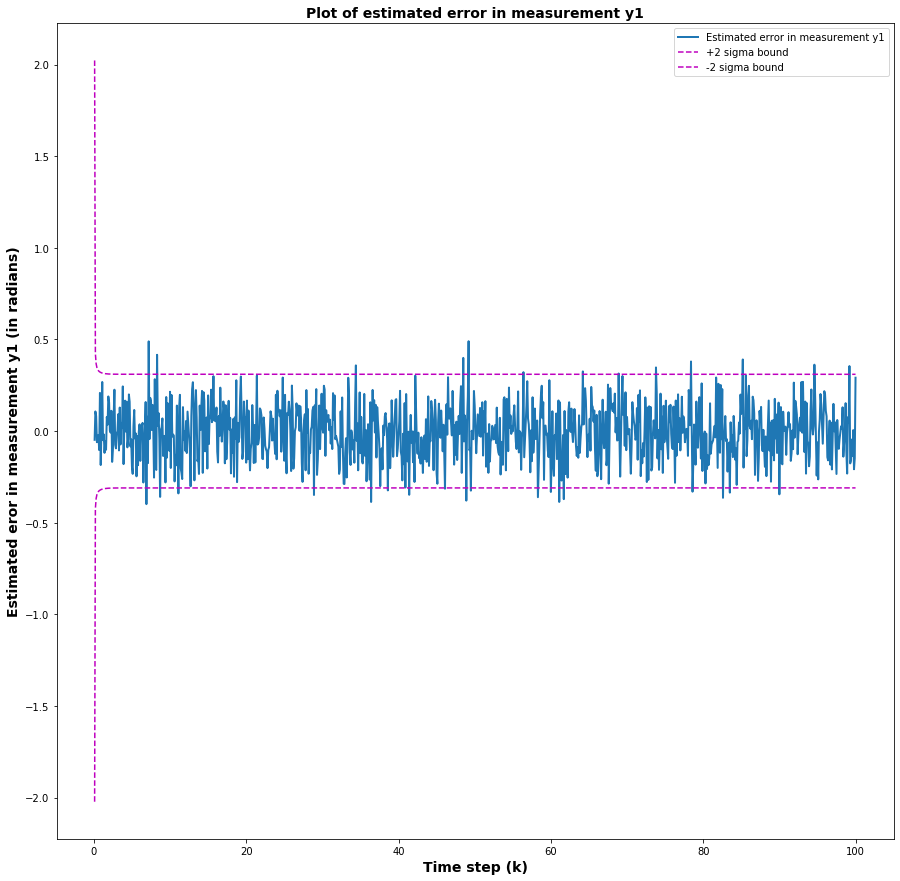

In [141]:
#Error in y1
estimated_measurement1_error_list = []
positive_two_sigma_state_measurement1_list = []
negative_two_sigma_state_measurement1_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y1[i]
    curr_variance = innovation_covariance_matrix_list[i][0][0]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y1[i] - curr_estimate
    curr_error = wrap_in_negative_pi_to_pi(curr_error)
    estimated_measurement1_error_list.append(curr_error)
    positive_two_sigma_state_measurement1_list.append(bound)
    negative_two_sigma_state_measurement1_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y1 (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y1",fontsize=14, fontweight='bold')
plt.plot(time_steps[1+skip_till:],estimated_measurement1_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y1')
plt.plot(time_steps[1+skip_till:],positive_two_sigma_state_measurement1_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[1+skip_till:],negative_two_sigma_state_measurement1_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

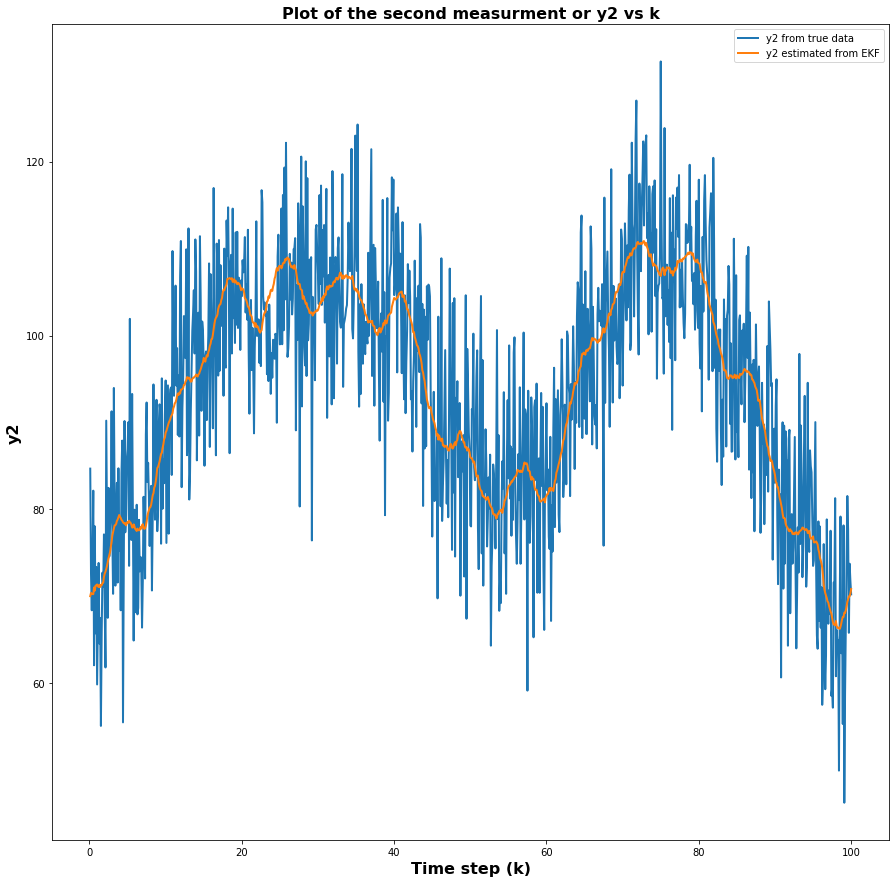

In [142]:
#Plot y[2]

true_y2 = []
estimated_y2 = []

for state in Ytrue[1:]:
    true_y2.append(state[1][0])
    
for state in estimated_measurement_list:
    estimated_y2.append(state[1][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y2",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y2 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps[1:],true_y2,linewidth = 2,label = 'y2 from true data')
plt.plot(time_steps[1:],estimated_y2,linewidth = 2,label = 'y2 estimated from EKF')
plt.legend()



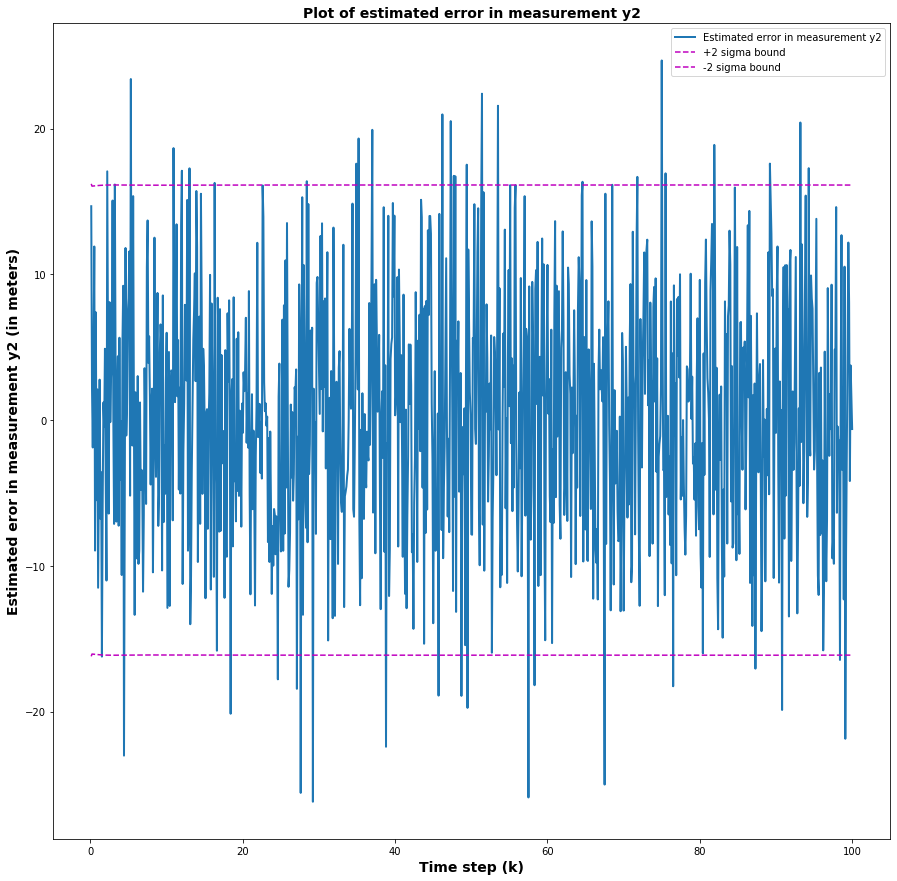

In [143]:
#Error in y2
estimated_measurement2_error_list = []
positive_two_sigma_state_measurement2_list = []
negative_two_sigma_state_measurement2_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y2[i]
    curr_variance = innovation_covariance_matrix_list[i][1][1]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y2[i] - curr_estimate
    estimated_measurement2_error_list.append(curr_error)
    positive_two_sigma_state_measurement2_list.append(bound)
    negative_two_sigma_state_measurement2_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y2 (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y2",fontsize=14, fontweight='bold')
plt.plot(time_steps[1+skip_till:],estimated_measurement2_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y2')
plt.plot(time_steps[1+skip_till:],positive_two_sigma_state_measurement2_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[1+skip_till:],negative_two_sigma_state_measurement2_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

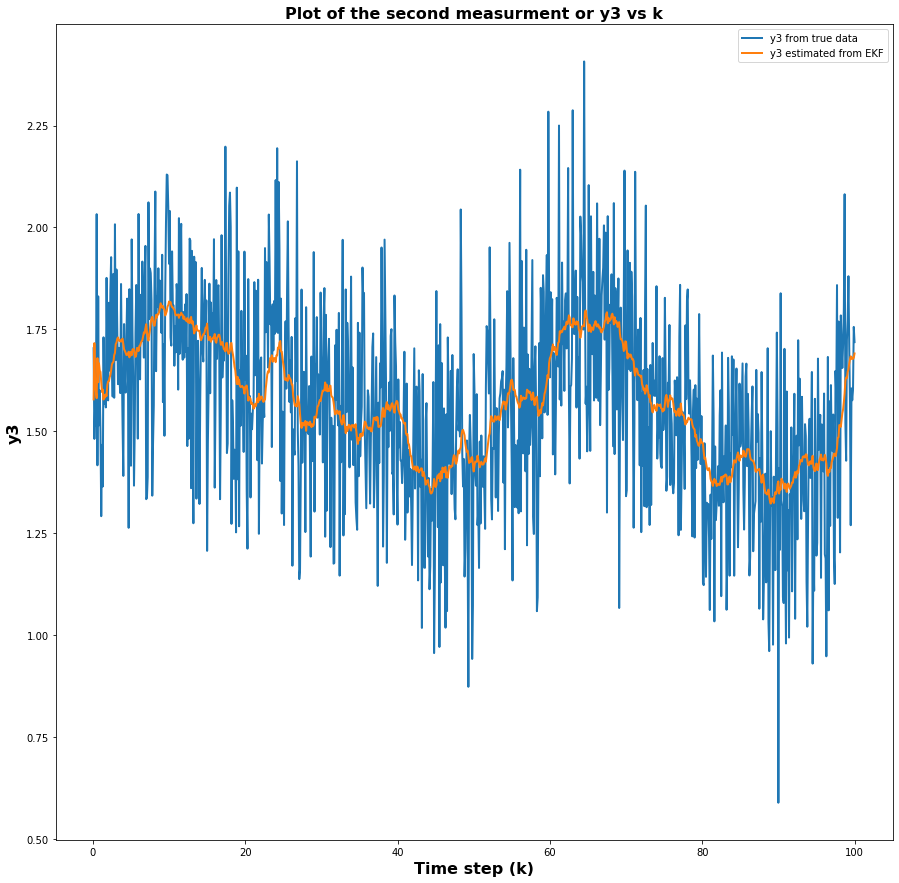

In [144]:
#Plot y[3]

true_y3 = []
estimated_y3 = []

for state in Ytrue[1:]:
    true_y3.append(state[2][0])
    
for state in estimated_measurement_list:
    estimated_y3.append(state[2][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y3",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y3 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps[1:],true_y3,linewidth = 2,label = 'y3 from true data')
plt.plot(time_steps[1:],estimated_y3,linewidth = 2,label = 'y3 estimated from EKF')
plt.legend()

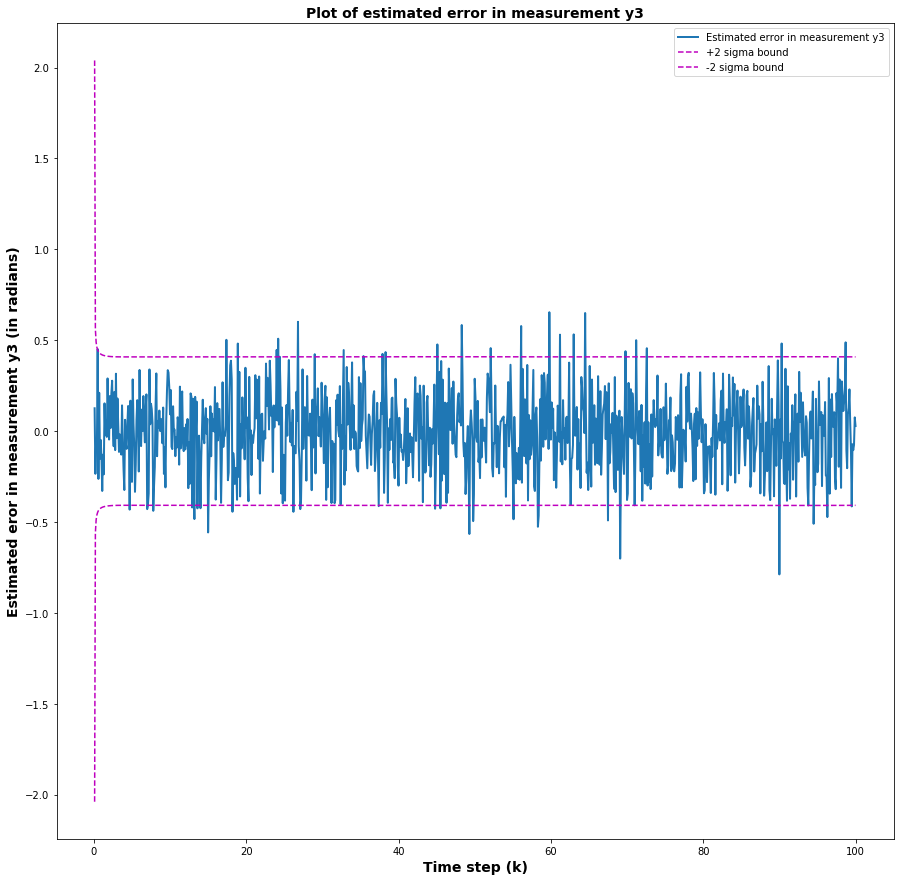

In [145]:
#Error in y3
estimated_measurement3_error_list = []
positive_two_sigma_state_measurement3_list = []
negative_two_sigma_state_measurement3_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y3[i]
    curr_variance = innovation_covariance_matrix_list[i][2][2]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y3[i] - curr_estimate
    curr_error = wrap_in_negative_pi_to_pi(curr_error)    
    estimated_measurement3_error_list.append(curr_error)
    positive_two_sigma_state_measurement3_list.append(bound)
    negative_two_sigma_state_measurement3_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y3 (in radians)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y3",fontsize=14, fontweight='bold')
plt.plot(time_steps[1+skip_till:],estimated_measurement3_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y3')
plt.plot(time_steps[1+skip_till:],positive_two_sigma_state_measurement3_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[1+skip_till:],negative_two_sigma_state_measurement3_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

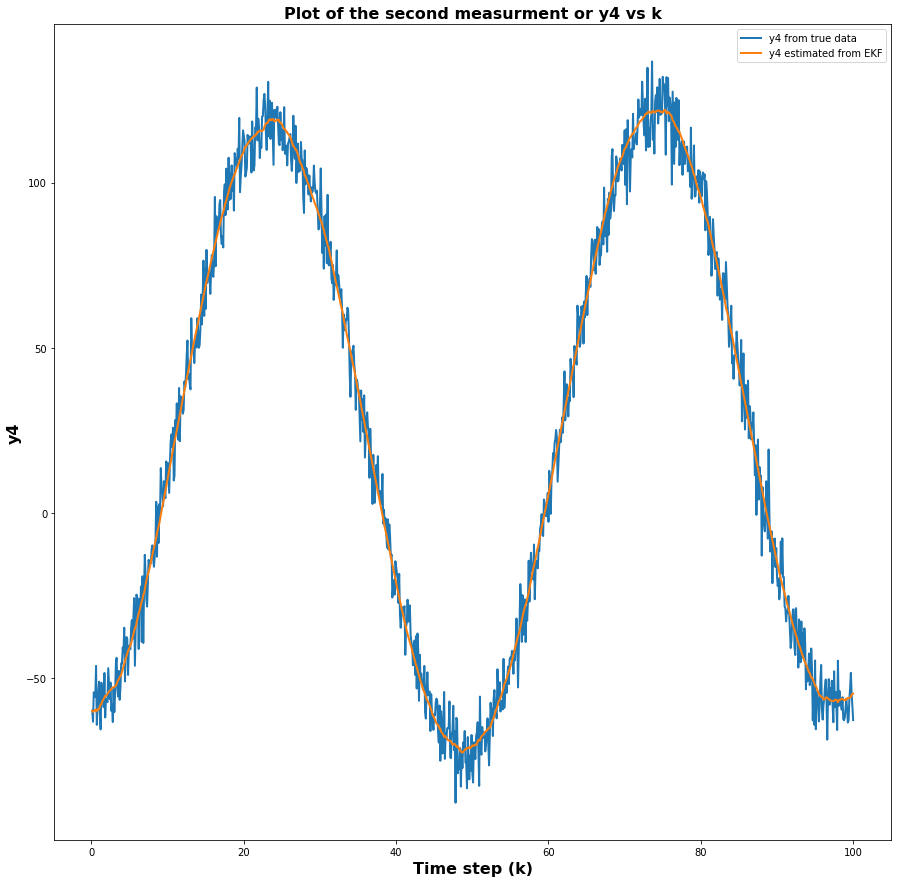

In [146]:
#Plot y[4]

true_y4 = []
estimated_y4 = []

for state in Ytrue[1:]:
    true_y4.append(state[3][0])
    
for state in estimated_measurement_list:
    estimated_y4.append(state[3][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y4",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y4 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps[1:],true_y4,linewidth = 2,label = 'y4 from true data')
plt.plot(time_steps[1:],estimated_y4,linewidth = 2,label = 'y4 estimated from EKF')
plt.legend()

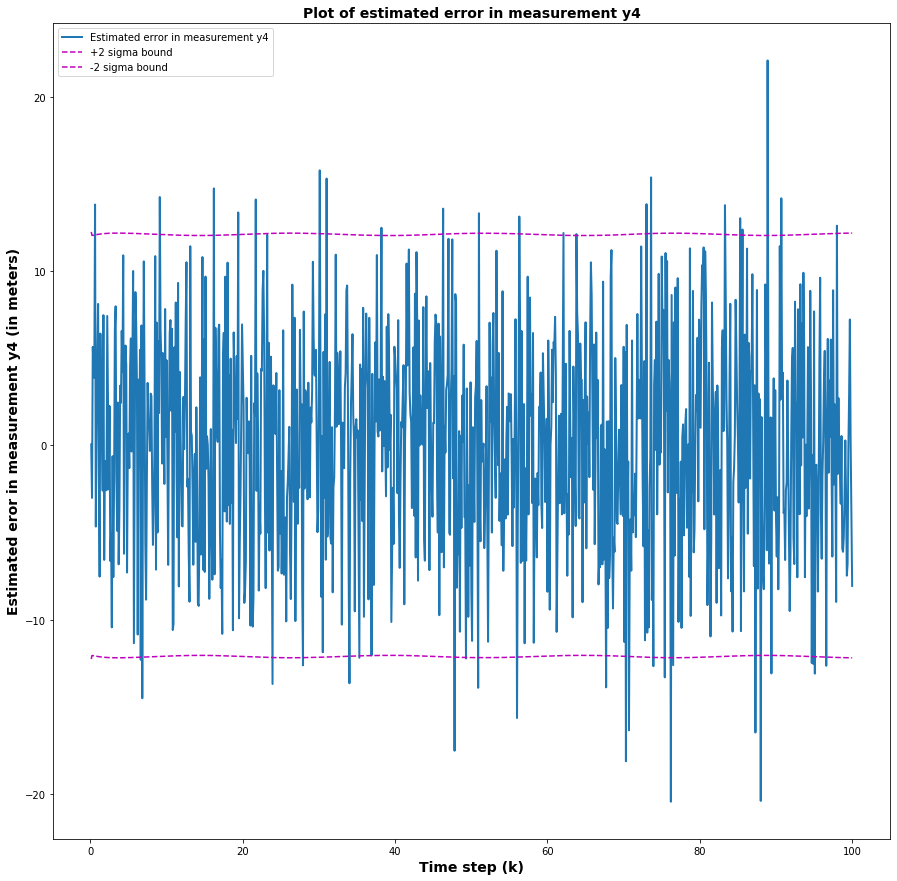

In [147]:
#Error in y4
estimated_measurement4_error_list = []
positive_two_sigma_state_measurement4_list = []
negative_two_sigma_state_measurement4_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y4[i]
    curr_variance = innovation_covariance_matrix_list[i][3][3]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y4[i] - curr_estimate
    estimated_measurement4_error_list.append(curr_error)
    positive_two_sigma_state_measurement4_list.append(bound)
    negative_two_sigma_state_measurement4_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y4 (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y4",fontsize=14, fontweight='bold')
plt.plot(time_steps[1+skip_till:],estimated_measurement4_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y4')
plt.plot(time_steps[1+skip_till:],positive_two_sigma_state_measurement4_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[1+skip_till:],negative_two_sigma_state_measurement4_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

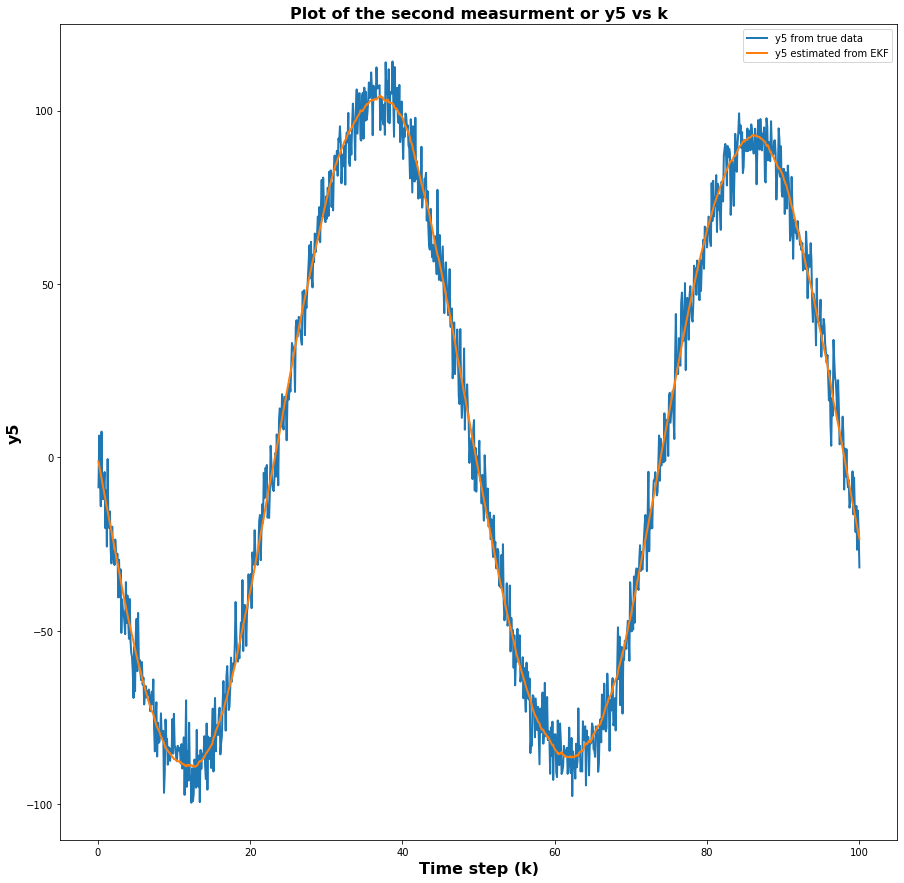

In [148]:
#Plot y[5]

true_y5 = []
estimated_y5 = []

for state in Ytrue[1:]:
    true_y5.append(state[4][0])
    
for state in estimated_measurement_list:
    estimated_y5.append(state[4][0])
    
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("y5",fontsize=16, fontweight='bold')
plt.title("Plot of the second measurment or y5 vs k",fontsize=16, fontweight='bold')
plt.plot(time_steps[1:],true_y5,linewidth = 2,label = 'y5 from true data')
plt.plot(time_steps[1:],estimated_y5,linewidth = 2,label = 'y5 estimated from EKF')
plt.legend()

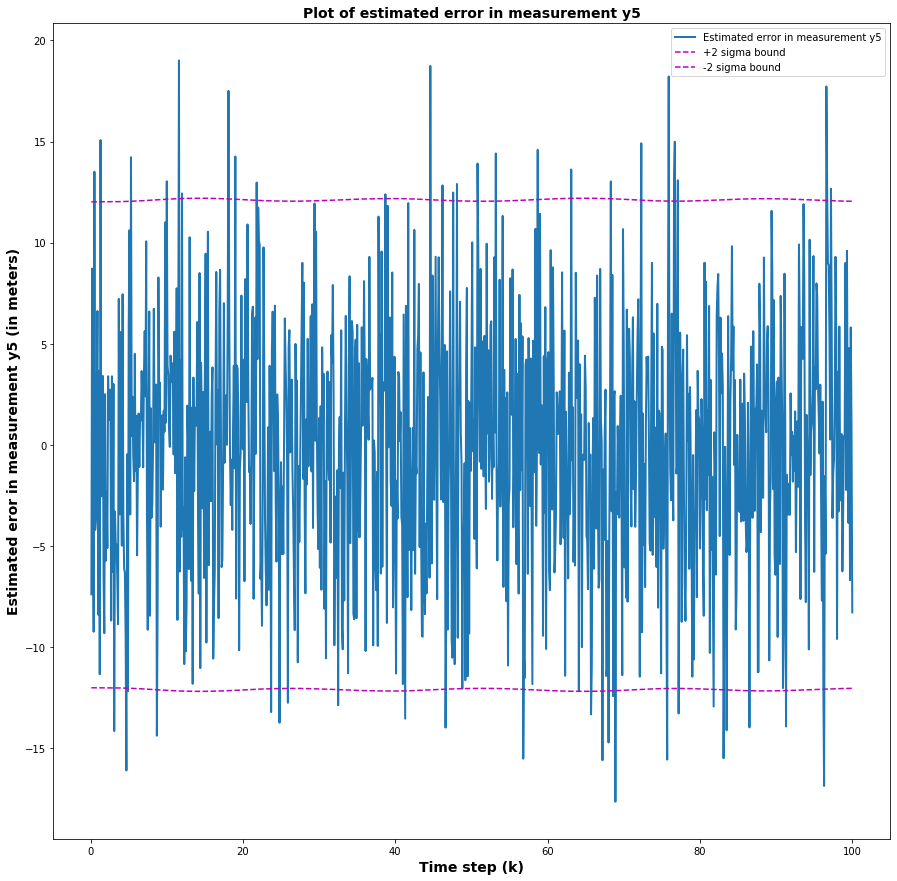

In [149]:
#Error in y5
estimated_measurement5_error_list = []
positive_two_sigma_state_measurement5_list = []
negative_two_sigma_state_measurement5_list = []

for i in range(0,len(estimated_measurement_list)):
    curr_estimate = estimated_y5[i]
    curr_variance = innovation_covariance_matrix_list[i][4][4]
    sigma = np.sqrt(curr_variance)
    bound = 2*sigma
    curr_error = true_y5[i] - curr_estimate
    estimated_measurement5_error_list.append(curr_error)
    positive_two_sigma_state_measurement5_list.append(bound)
    negative_two_sigma_state_measurement5_list.append(-bound)

plt.xlabel("Time step (k)",fontsize=14, fontweight='bold')
plt.ylabel("Estimated eror in measurement y5 (in meters)",fontsize=14, fontweight='bold')
plt.title("Plot of estimated error in measurement y5",fontsize=14, fontweight='bold')
plt.plot(time_steps[1+skip_till:],estimated_measurement5_error_list[skip_till:],linewidth = 2,label = 'Estimated error in measurement y5')
plt.plot(time_steps[1+skip_till:],positive_two_sigma_state_measurement5_list[skip_till:],'--m',label = '+2 sigma bound')
plt.plot(time_steps[1+skip_till:],negative_two_sigma_state_measurement5_list[skip_till:],'--m',label = '-2 sigma bound')
plt.legend()

In [150]:
num_mc_simulations = 500
NEES_data,NIS_data = get_NEES_data_for_multiple_simulations(x0,Pstart,u,Qtrue,Rtrue,Qfilter,Rtrue,num_mc_simulations)

Performing simulation number 0
Performing simulation number 1
Performing simulation number 2
Performing simulation number 3
Performing simulation number 4
Performing simulation number 5
Performing simulation number 6
Performing simulation number 7
Performing simulation number 8
Performing simulation number 9
Performing simulation number 10
Performing simulation number 11
Performing simulation number 12
Performing simulation number 13
Performing simulation number 14
Performing simulation number 15
Performing simulation number 16
Performing simulation number 17
Performing simulation number 18
Performing simulation number 19
Performing simulation number 20
Performing simulation number 21
Performing simulation number 22
Performing simulation number 23
Performing simulation number 24
Performing simulation number 25
Performing simulation number 26
Performing simulation number 27
Performing simulation number 28
Performing simulation number 29
Performing simulation number 30
Performing simulat

Performing simulation number 252
Performing simulation number 253
Performing simulation number 254
Performing simulation number 255
Performing simulation number 256
Performing simulation number 257
Performing simulation number 258
Performing simulation number 259
Performing simulation number 260
Performing simulation number 261
Performing simulation number 262
Performing simulation number 263
Performing simulation number 264
Performing simulation number 265
Performing simulation number 266
Performing simulation number 267
Performing simulation number 268
Performing simulation number 269
Performing simulation number 270
Performing simulation number 271
Performing simulation number 272
Performing simulation number 273
Performing simulation number 274
Performing simulation number 275
Performing simulation number 276
Performing simulation number 277
Performing simulation number 278
Performing simulation number 279
Performing simulation number 280
Performing simulation number 281
Performing

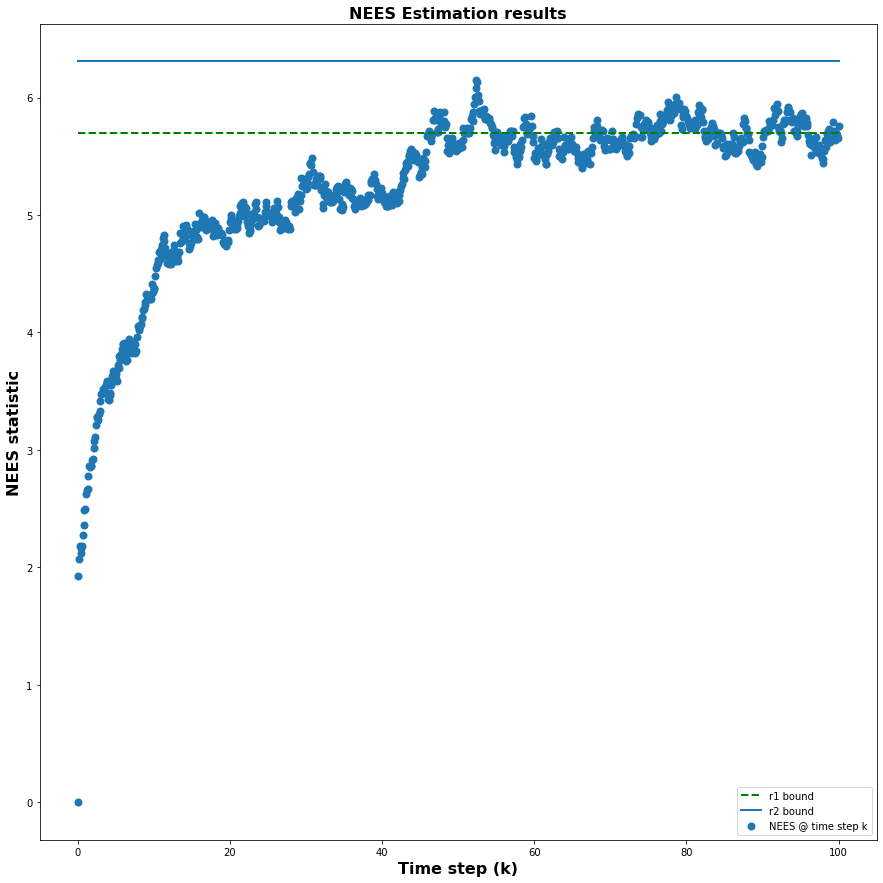

In [151]:
NEES_mean_list = NEES_data.mean(axis=0)
N = num_mc_simulations
n = len(x0)
r1 = chi2.ppf(0.025, df=N*n)/N
r2 = chi2.ppf(0.975, df=N*n)/N

#plt.plot(time_steps,NEES_mean_list)
r1_bound = [r1]*len(time_steps)
r2_bound = [r2]*len(time_steps)
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("NEES statistic",fontsize=16, fontweight='bold')
plt.title("NEES Estimation results",fontsize=16, fontweight='bold')
plt.scatter(time_steps,NEES_mean_list,linewidth = 2,label = 'NEES @ time step k')
plt.plot(time_steps,r1_bound,'--g',linewidth = 2,label = 'r1 bound')
plt.plot(time_steps,r2_bound,linewidth = 2,label = 'r2 bound')
plt.legend()

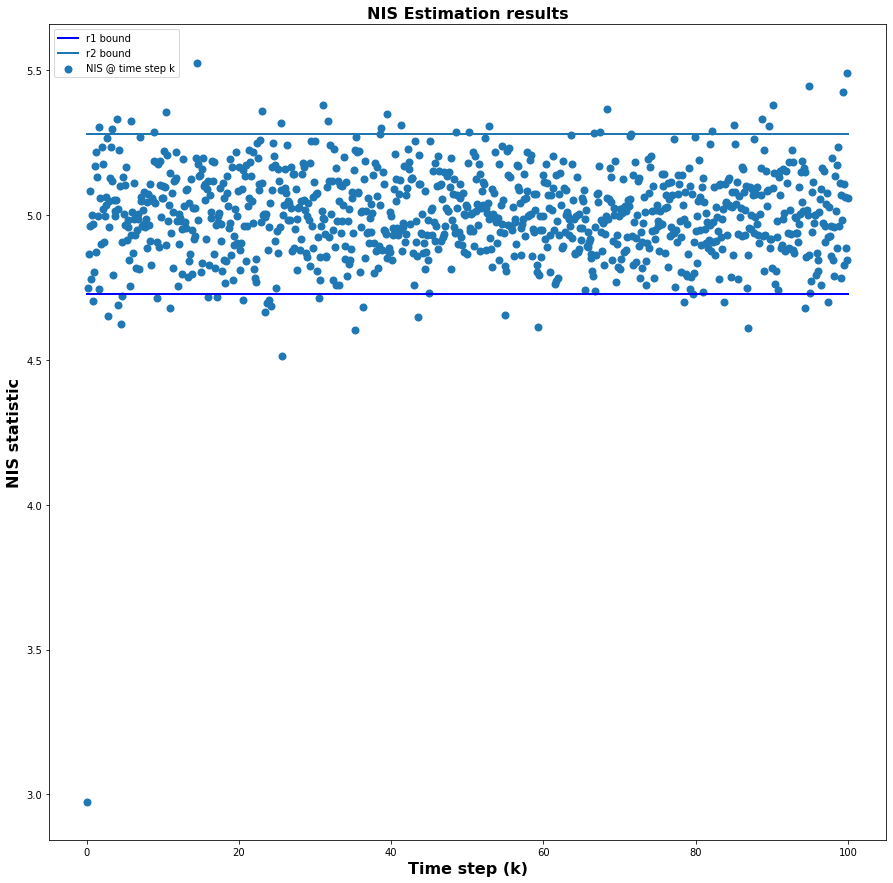

In [152]:
NIS_mean_list = NIS_data.mean(axis=0)
N = num_mc_simulations
p = len(Rtrue)
r1 = chi2.ppf(0.025, df=N*p)/N
r2 = chi2.ppf(0.975, df=N*p)/N

#plt.plot(time_steps,NEES_mean_list)
r1_bound = [r1]*len(time_steps[1:])
r2_bound = [r2]*len(time_steps[1:])
plt.xlabel("Time step (k)",fontsize=16, fontweight='bold')
plt.ylabel("NIS statistic",fontsize=16, fontweight='bold')
plt.title("NIS Estimation results",fontsize=16, fontweight='bold')
plt.scatter(time_steps[1:],NIS_mean_list,linewidth = 2,label = 'NIS @ time step k')
plt.plot(time_steps[1:],r1_bound,'b',linewidth = 2,label = 'r1 bound')
plt.plot(time_steps[1:],r2_bound,linewidth = 2,label = 'r2 bound')
plt.legend()

In [157]:
inv(estimated_covariance_matrix_list[299])

array([[ 7.95979242e+00,  9.05599635e-02, -1.53414528e+00,
        -6.81316974e-01,  5.96215356e-01, -3.41141838e+00],
       [ 9.05599635e-02,  7.13512106e+00, -8.59851010e+00,
        -1.74631655e-01, -6.00452412e-01, -4.14905710e+00],
       [-1.53414528e+00, -8.59851010e+00,  7.05791532e+02,
         4.02711505e+00, -4.04977754e+00,  4.48645773e+00],
       [-6.81316974e-01, -1.74631655e-01,  4.02711505e+00,
         1.69822832e+00, -6.99477206e-01,  1.36926791e+01],
       [ 5.96215356e-01, -6.00452412e-01, -4.04977754e+00,
        -6.99477206e-01,  3.62397600e+00,  2.13778325e+01],
       [-3.41141838e+00, -4.14905710e+00,  4.48645773e+00,
         1.36926791e+01,  2.13778325e+01,  9.18313488e+02]])

In [155]:
np.linalg.pinv(estimated_covariance_matrix_list[299])

array([[ 7.95979242e+00,  9.05599635e-02, -1.53414528e+00,
        -6.81316974e-01,  5.96215356e-01, -3.41141838e+00],
       [ 9.05599635e-02,  7.13512106e+00, -8.59851010e+00,
        -1.74631655e-01, -6.00452412e-01, -4.14905710e+00],
       [-1.53414528e+00, -8.59851010e+00,  7.05791532e+02,
         4.02711505e+00, -4.04977754e+00,  4.48645773e+00],
       [-6.81316974e-01, -1.74631655e-01,  4.02711505e+00,
         1.69822832e+00, -6.99477206e-01,  1.36926791e+01],
       [ 5.96215356e-01, -6.00452412e-01, -4.04977754e+00,
        -6.99477206e-01,  3.62397600e+00,  2.13778325e+01],
       [-3.41141838e+00, -4.14905710e+00,  4.48645773e+00,
         1.36926791e+01,  2.13778325e+01,  9.18313488e+02]])